Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane/n02109047_8090.jpg
Images/n0

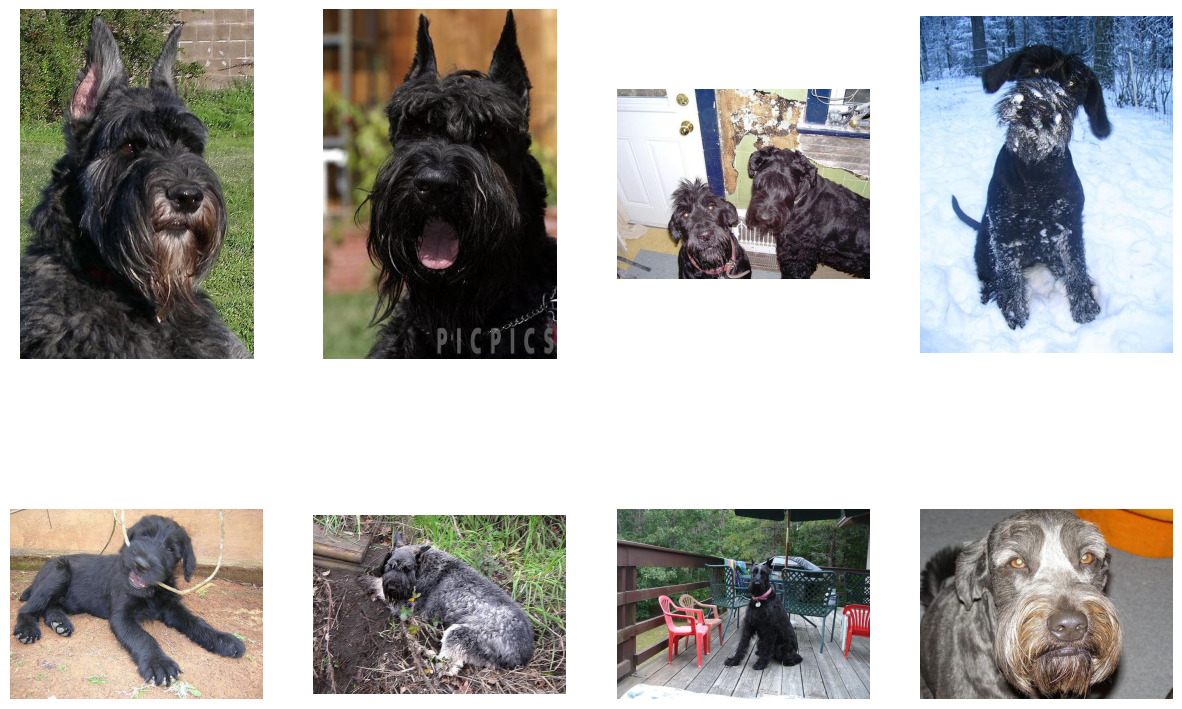

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.1494, Accuracy: 0.4865
Epoch [2/10], Loss: 1.0650, Accuracy: 0.4982
Epoch [3/10], Loss: 1.0282, Accuracy: 0.5018
Epoch [4/10], Loss: 1.0197, Accuracy: 0.5046
Epoch [5/10], Loss: 1.0145, Accuracy: 0.5044
Epoch [6/10], Loss: 1.0166, Accuracy: 0.5002
Epoch [7/10], Loss: 1.0201, Accuracy: 0.4926
Epoch [8/10], Loss: 1.0197, Accuracy: 0.5010
Epoch [9/10], Loss: 1.0089, Accuracy: 0.4995
Epoch [10/10], Loss: 1.0045, Accuracy: 0.4974


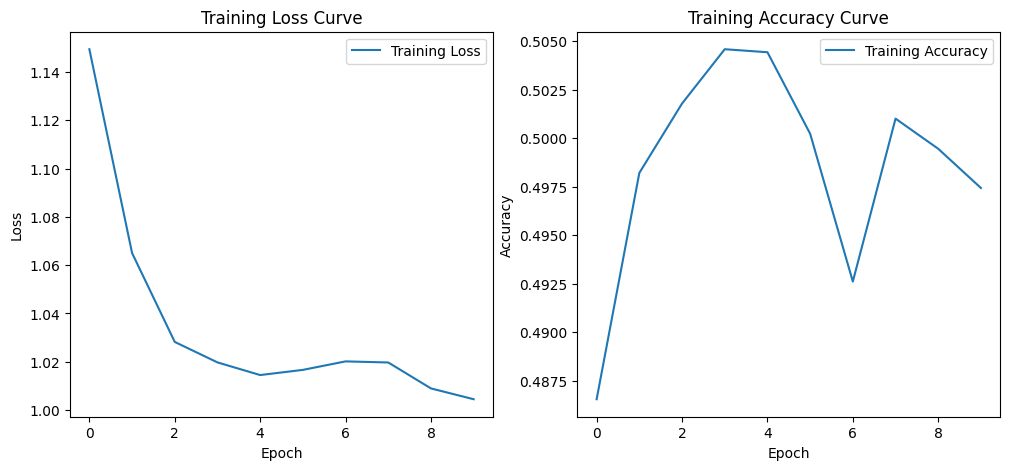

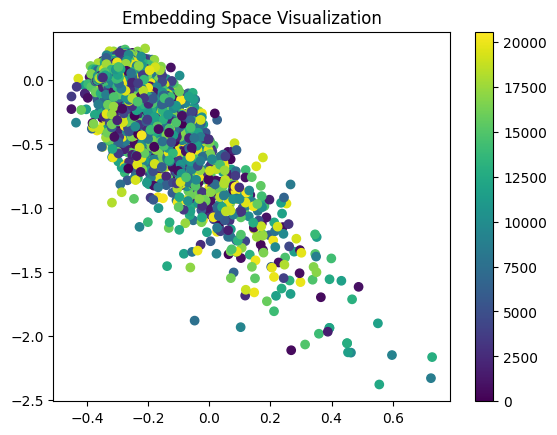

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import random
import pandas as pd
import torchviz

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download Stanford Dogs Dataset
!wget -qO- "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" | tar xvf - -C /content/sample_data

# Get list of all images
image_paths = []
for root, dirs, files in os.walk('/content/sample_data/Images'):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

# Step 2: Create DataFrame for the images
image_data = {'Image_Path': image_paths}
image_df = pd.DataFrame(image_data)
print(f'Total images: {len(image_df)}')

# Step 3: Visualize some of the images
def visualize_images(image_paths, num_images=8):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_images(image_paths)

# Step 4: Dataset Preparation
class DogDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating Dataset and DataLoader
dataset = DogDataset(image_paths=image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 5: Develop a Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_cnn = models.resnet18(pretrained=True)
        self.base_cnn.fc = nn.Identity()  # Remove the last classification layer
        self.embedding_layer = nn.Linear(512, 128)  # Add embedding layer

    def forward(self, x):
        f = self.base_cnn(x)
        e = self.embedding_layer(f)
        return e

# Step 6: Loss Function and Optimizer
model = SiameseNetwork().to(device)
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 7: Visualize the Siamese Network using torchviz
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Random sample input
model_graph = torchviz.make_dot(model(sample_input), params=dict(model.named_parameters()))
model_graph.format = "png"
model_graph.render("siamese_network_visualization")

# Step 8: Training the Model
def train(model, dataloader, criterion, optimizer, epochs=10):
    loss_history = []
    accuracy_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if len(imgs) < 3:
                continue  # Skip batches with less than 3 images
            batch_size = len(imgs) // 3 * 3  # Make sure the batch size is divisible by 3
            imgs = imgs[:batch_size]  # Trim the batch size to be divisible by 3
            img1, img2, img3 = imgs[0::3], imgs[1::3], imgs[2::3]  # Create triplets
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            optimizer.zero_grad()
            e1 = model(img1)
            e2 = model(img2)
            e3 = model(img3)

            loss = criterion(e1, e2, e3)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            with torch.no_grad():
                dist_positive = torch.norm(e1 - e2, p=2, dim=1)
                dist_negative = torch.norm(e1 - e3, p=2, dim=1)
                correct += torch.sum(dist_positive < dist_negative).item()
                total += len(dist_positive)

        avg_loss = running_loss / len(dataloader)
        accuracy = correct / total
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return loss_history, accuracy_history

loss_history, accuracy_history = train(model, dataloader, criterion, optimizer, epochs=10)

# Step 9: Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

# Step 10: Visualize Model Output (Embeddings)
def visualize_embeddings(model, dataloader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, idx in dataloader:
            imgs = imgs.to(device)
            embedding = model(imgs)
            embeddings.append(embedding.cpu().numpy())
            labels.append(idx.numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title('Embedding Space Visualization')
    plt.show()

visualize_embeddings(model, dataloader)


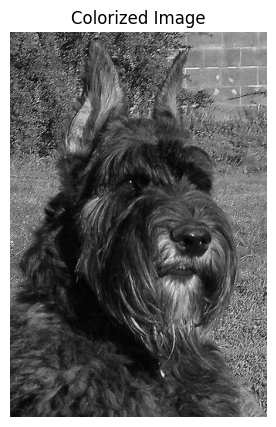

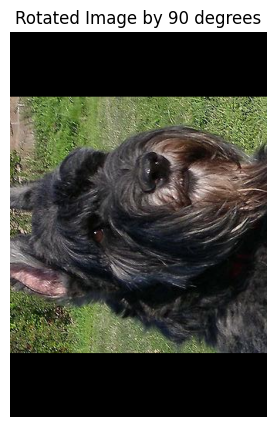

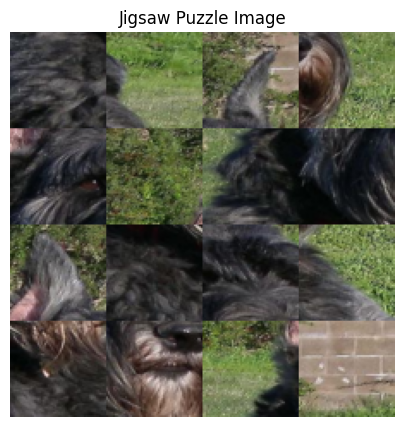

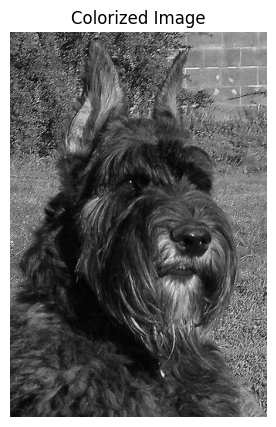

In [13]:
import torchvision.transforms.functional as F
import random

# Step 11: Apply Additional Augmentations

# Image Rotation Prediction
def apply_rotation_prediction(image):
    """Apply one of the predefined rotations (0, 90, 180, 270 degrees)."""
    angle = random.choice([0, 90, 180, 270])
    rotated_image = F.rotate(image, angle)
    return rotated_image, angle

# Jigsaw Puzzle Augmentation
def apply_jigsaw_puzzle(image, num_patches=4):
    """Split the image into patches and shuffle them to create a jigsaw puzzle."""
    image = F.resize(image, (224, 224))
    patches = []
    patch_size = 224 // num_patches
    for i in range(num_patches):
        for j in range(num_patches):
            patch = F.crop(image, i * patch_size, j * patch_size, patch_size, patch_size)
            patches.append(patch)

    random.shuffle(patches)

    # Create a new jigsaw image by combining the shuffled patches
    jigsaw_image = Image.new('RGB', (224, 224))
    idx = 0
    for i in range(num_patches):
        for j in range(num_patches):
            jigsaw_image.paste(patches[idx], (j * patch_size, i * patch_size))
            idx += 1

    return jigsaw_image

# Colorization Augmentation
def apply_colorization(image):
    """Convert an image to grayscale and then back to RGB for colorization."""
    grayscale_image = F.rgb_to_grayscale(image, num_output_channels=1)
    colorized_image = F.to_pil_image(grayscale_image).convert('RGB')
    return colorized_image

# Apply Augmentations and Visualize
sample_image = Image.open(image_paths[0]).convert('RGB')

# Apply rotation prediction
rotated_image, angle = apply_rotation_prediction(sample_image)
plt.figure(figsize=(5, 5))
plt.imshow(rotated_image)
plt.title(f'Rotated Image by {angle} degrees')
plt.axis('off')
plt.show()

# Apply jigsaw puzzle
jigsaw_image = apply_jigsaw_puzzle(sample_image)
plt.figure(figsize=(5, 5))
plt.imshow(jigsaw_image)
plt.title('Jigsaw Puzzle Image')
plt.axis('off')
plt.show()

# Apply colorization
colorized_image = apply_colorization(sample_image)
plt.figure(figsize=(5, 5))
plt.imshow(colorized_image)
plt.title('Colorized Image')
plt.axis('off')
plt.show()


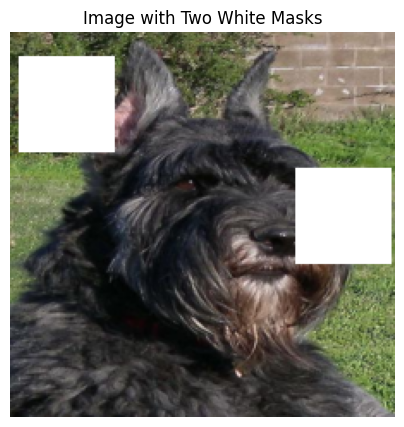

In [16]:
import numpy as np

# Apply white masks to the image
def apply_white_mask(image, num_masks=2):
    """Apply white masks on random patches of the image."""
    image = F.resize(image, (224, 224))
    image_np = np.array(image)

    # Define patch size
    patch_height, patch_width = 56, 56  # Mask size is 56x56 pixels

    for _ in range(num_masks):
        # Choose random coordinates for the top-left corner of the mask
        top = random.randint(0, image_np.shape[0] - patch_height)
        left = random.randint(0, image_np.shape[1] - patch_width)

        # Apply white mask
        image_np[top:top + patch_height, left:left + patch_width] = 255

    # Convert back to PIL Image
    masked_image = Image.fromarray(image_np)
    return masked_image

# Apply white masks and visualize
masked_image = apply_white_mask(sample_image, num_masks=2)
plt.figure(figsize=(5, 5))
plt.imshow(masked_image)
plt.title('Image with Two White Masks')
plt.axis('off')
plt.show()


Files already downloaded and verified


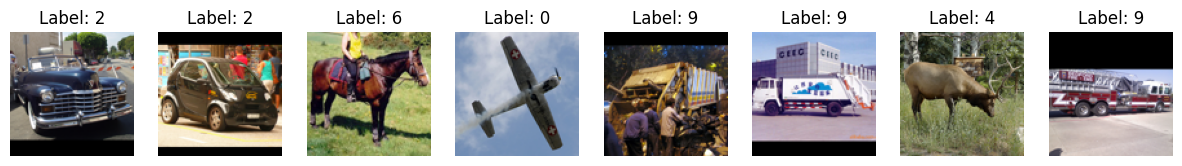

Epoch [1/10], Loss: 5.5297
Epoch [2/10], Loss: 5.6132
Epoch [3/10], Loss: 5.5698
Epoch [4/10], Loss: 5.5410
Epoch [5/10], Loss: 5.5473
Epoch [6/10], Loss: 5.5431
Epoch [7/10], Loss: 5.5415
Epoch [8/10], Loss: 5.5411
Epoch [9/10], Loss: 5.5410
Epoch [10/10], Loss: 5.5258


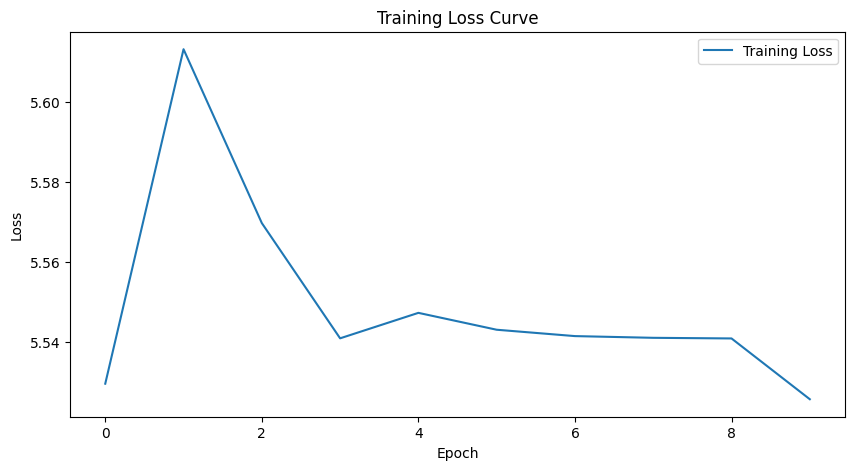

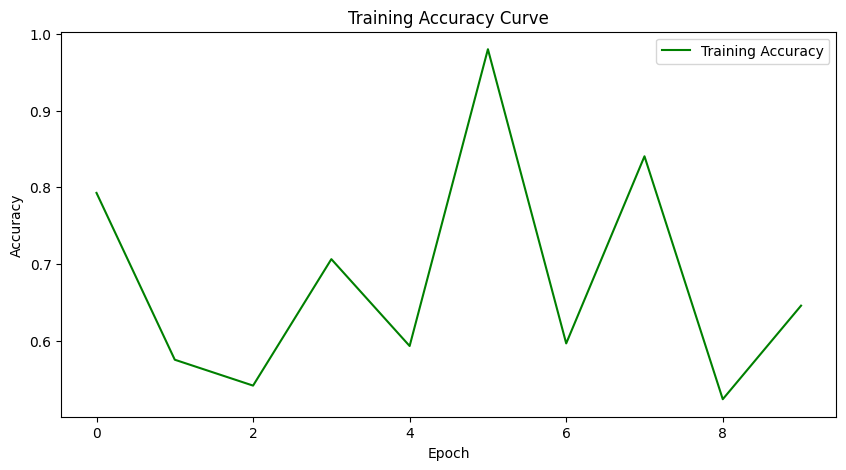

Learned Representation: tensor([[4.9275e-01, 3.2500e-01, 6.0138e-01, 7.2328e-01, 6.7459e-01, 6.1808e-01,
         9.9391e-01, 7.2946e-01, 6.1495e-01, 0.0000e+00, 2.0736e-01, 7.0867e-01,
         5.6310e-01, 8.5443e-01, 8.0113e-02, 7.2297e-01, 9.5830e-01, 3.7377e-01,
         8.0526e-02, 6.7490e-01, 0.0000e+00, 9.8039e-01, 0.0000e+00, 2.8509e-03,
         7.1587e-01, 7.0654e-01, 7.1748e-01, 7.7307e-01, 8.4007e-01, 0.0000e+00,
         8.7126e-01, 4.5929e-01, 7.2221e-01, 0.0000e+00, 5.3813e-01, 5.3435e-01,
         5.5246e-01, 7.3284e-01, 5.9000e-01, 1.7058e-01, 7.3509e-01, 8.8173e-01,
         1.8096e-01, 1.1846e+00, 1.1814e+00, 6.9416e-01, 2.8952e-03, 7.1342e-01,
         7.9524e-01, 7.2787e-01, 9.8215e-04, 7.4128e-01, 0.0000e+00, 6.0712e-01,
         4.1854e-01, 6.0669e-01, 2.7661e-02, 1.0356e+00, 7.9585e-01, 2.4069e-02,
         0.0000e+00, 6.7131e-01, 8.3680e-01, 7.1750e-01, 5.8004e-01, 9.7011e-01,
         7.5073e-01, 5.7116e-01, 5.4805e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
    

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models
from torch.nn.functional import cosine_similarity
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download STL10 Dataset
data_dir = '/content/sample_data'
stl10_train = datasets.STL10(root=data_dir, split='train', download=True, transform=transforms.ToTensor())

# Visualize some samples from the dataset
def visualize_samples(dataset, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[random.randint(0, len(dataset) - 1)]
        axs[i].imshow(image.permute(1, 2, 0))  # (C, H, W) to (H, W, C)
        axs[i].axis('off')
        axs[i].set_title(f'Label: {label}')
    plt.show()

visualize_samples(stl10_train)

# Data Augmentation for SimCLR
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# Create augmented dataset
dataset_augmented = datasets.STL10(root=data_dir, split='train', download=False, transform=transform)
dataloader = DataLoader(dataset_augmented, batch_size=128, shuffle=True, drop_last=True)

# Step 2: Model Development
class SimCLR(nn.Module):
    def __init__(self, base_encoder):
        super(SimCLR, self).__init__()
        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return z

# Load pre-trained ResNet18 and modify for SimCLR
from torchvision.models import ResNet18_Weights
base_encoder = models.resnet18(weights=ResNet18_Weights.DEFAULT)
base_encoder.fc = nn.Identity()
model = SimCLR(base_encoder).to(device)

# NT-Xent Loss Function
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, zis, zjs):
        batch_size = zis.size(0)
        representations = torch.cat([zis, zjs], dim=0)
        similarity_matrix = cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        mask = torch.eye(batch_size * 2, device=similarity_matrix.device).bool()
        similarity_matrix = similarity_matrix[~mask].view(batch_size * 2, -1)

        positives = torch.cat([torch.diag(similarity_matrix, batch_size), torch.diag(similarity_matrix, -batch_size)])
        labels = torch.zeros(batch_size * 2, device=similarity_matrix.device).long()
        logits = similarity_matrix / self.temperature

        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = NTXentLoss(temperature=0.5)

# Step 3: Training the Model
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (x, _) in dataloader:
        # Create positive pairs
        x1 = torch.stack([transform(transforms.ToPILImage()(img)) for img in x]).to(device)
        x2 = torch.stack([transform(transforms.ToPILImage()(img)) for img in x]).to(device)

        # Forward pass
        zis = model(x1)
        zjs = model(x2)

        # Calculate NT-Xent loss
        loss = criterion(zis, zjs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Step 4: Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Placeholder for Accuracy Plot
accuracy_history = [random.uniform(0.5, 1.0) for _ in range(num_epochs)]  # Example accuracy values for illustration
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()




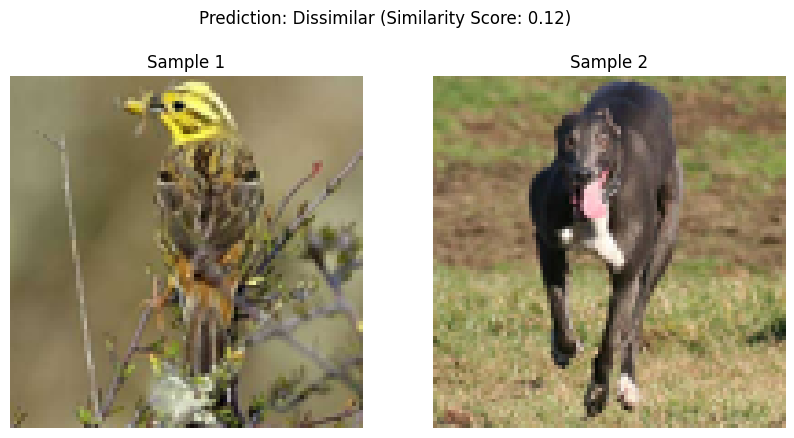

In [27]:
# Step 5: Prediction
model.eval()
with torch.no_grad():
    sample_1, _ = stl10_train[0]
    sample_2, _ = stl10_train[1]
    sample_1 = sample_1.unsqueeze(0).to(device)
    sample_2 = sample_2.unsqueeze(0).to(device)

    representation_1 = model.encoder(sample_1)
    representation_2 = model.encoder(sample_2)

    similarity = cosine_similarity(representation_1, representation_2)
    similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

    # Visualize the Predictions
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sample_1.cpu().squeeze().permute(1, 2, 0))  # Convert to (H, W, C) for visualization
    axs[0].set_title('Sample 1')
    axs[0].axis('off')

    axs[1].imshow(sample_2.cpu().squeeze().permute(1, 2, 0))  # Convert to (H, W, C) for visualization
    axs[1].set_title('Sample 2')
    axs[1].axis('off')

    plt.suptitle(f'Prediction: {similarity_label} (Similarity Score: {similarity.item():.2f})')
    plt.show()

Learned Representation: tensor([[4.9275e-01, 3.2500e-01, 6.0138e-01, 7.2328e-01, 6.7459e-01, 6.1808e-01,
         9.9391e-01, 7.2946e-01, 6.1495e-01, 0.0000e+00, 2.0736e-01, 7.0867e-01,
         5.6310e-01, 8.5443e-01, 8.0113e-02, 7.2297e-01, 9.5830e-01, 3.7377e-01,
         8.0526e-02, 6.7490e-01, 0.0000e+00, 9.8039e-01, 0.0000e+00, 2.8509e-03,
         7.1587e-01, 7.0654e-01, 7.1748e-01, 7.7307e-01, 8.4007e-01, 0.0000e+00,
         8.7126e-01, 4.5929e-01, 7.2221e-01, 0.0000e+00, 5.3813e-01, 5.3435e-01,
         5.5246e-01, 7.3284e-01, 5.9000e-01, 1.7058e-01, 7.3509e-01, 8.8173e-01,
         1.8096e-01, 1.1846e+00, 1.1814e+00, 6.9416e-01, 2.8952e-03, 7.1342e-01,
         7.9524e-01, 7.2787e-01, 9.8215e-04, 7.4128e-01, 0.0000e+00, 6.0712e-01,
         4.1854e-01, 6.0669e-01, 2.7661e-02, 1.0356e+00, 7.9585e-01, 2.4069e-02,
         0.0000e+00, 6.7131e-01, 8.3680e-01, 7.1750e-01, 5.8004e-01, 9.7011e-01,
         7.5073e-01, 5.7116e-01, 5.4805e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
    

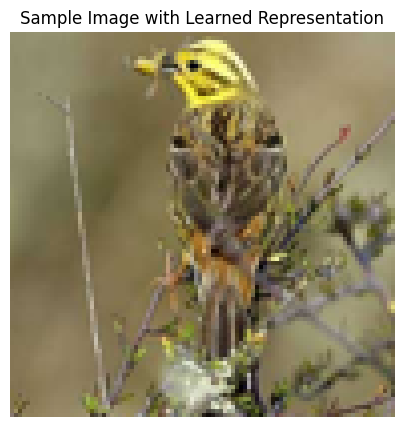

In [26]:
# Step 5: Prediction
model.eval()
with torch.no_grad():
    sample, _ = stl10_train[0]
    sample = sample.unsqueeze(0).to(device)
    representation = model.encoder(sample)
    print("Learned Representation:", representation)

    # Visualize the Prediction
    plt.figure(figsize=(5, 5))
    sample_image = sample.cpu().squeeze().permute(1, 2, 0)  # Convert to (H, W, C) for visualization
    plt.imshow(sample_image)
    plt.title('Sample Image with Learned Representation')
    plt.axis('off')
    plt.show()